In [1]:
%reload_ext kedro.ipython

[02/17/25 20:26:48] INFO     Using                                                                  ]8;id=97660;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/framework/project/__init__.py\__init__.py]8;;\:]8;id=750216;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/framework/project/__init__.py#270\270]8;;\
                             '/home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/sit                
                             e-packages/kedro/framework/project/rich_logging.yml' as logging                       
                             configuration.                                                                        

                    INFO     Registered line magic '%reload_kedro'                                   ]8;id=650990;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=654349;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#63\63]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=634092;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=36024;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#65\65]8;;\

                    INFO     Resolved project path as:                                              ]8;id=913844;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=408340;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#180\180]8;;\
                             /home/guilherme/Projects/credit-risk-analysis.                                        
                             To set a different path, run '%reload_kedro <project_root>'                           

[02/17/25 20:26:49] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=387576;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=371877;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro_telemetry/plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[02/17/25 20:26:50] INFO     Kedro project Credit Risk Analysis                                     ]8;id=702200;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=290153;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=346038;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=486881;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#147\147]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=424482;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=818223;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#153\153]8;;\

# Importando bibliotecas

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Funções úteis

In [3]:
def verify(df):
    print(df.shape)
    display(df.head())
    display(df.tail())

def display_info_dataframe(df):
    df_info = pd.concat([df.dtypes, df.isna().sum(), df.nunique()], axis=1)
    df_info.columns = ['dtype', 'qtd_nulos', 'qtd_unicos']
    display(df_info)

def ks_score(y_true, y_pred):
    """_summary_

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    df2 = pd.DataFrame({"bad": y_true, "score": y_pred})

    df2["good"] = 1 - df2.bad
    df2["bucket"] = pd.qcut(df2["score"], 10, duplicates="drop")

    grouped = df2.groupby("bucket")
    agg1 = (
        pd.DataFrame(grouped.min()["score"])
        .rename(columns={"score": "min_scr"})
        .copy()
    )
    agg1["max_scr"] = grouped.max()["score"]
    agg1["bads"] = grouped.sum().bad
    agg1["goods"] = grouped.sum().good
    agg1["total"] = agg1.bads + agg1.goods

    agg2 = (agg1.sort_values(by="min_scr")).reset_index(drop=True)
    agg2["odds"] = (agg2.goods / agg2.bads).apply("{0:.2f}".format)
    agg2["bad_rate"] = (agg2.bads / agg2.total).apply("{0:.2%}".format)
    agg2["ks"] = (
        np.round(
            (
                (agg2.bads / df2.bad.sum()).cumsum()
                - (agg2.goods / df2.good.sum()).cumsum()  # noqa: W503
            ),
            4,
        )  # noqa: W503
        * 100  # noqa: W503
    )

    flag = lambda x: "<----" if x == agg2.ks.max() else ""  # noqa: E731
    agg2["max_ks"] = agg2.ks.apply(flag)
    return max(abs(agg2.ks))

# Lendo as bases

In [4]:
df_completo = catalog.load("features_data")

                    INFO     Loading data from features_data (ParquetDataset)...                ]8;id=82393;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160932;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#390\390]8;;\

In [5]:
verify(df_completo)

(77195, 18)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RZ_RENDA_FUNC,VL_TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,2013-08-22,99,None,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,2482.597059
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,2013-08-22,99,None,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,1241.298879
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,2013-08-22,99,None,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,1218.494004
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,2013-08-22,99,None,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,93.735900
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,2013-08-22,99,None,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,1489.558515


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RZ_RENDA_FUNC,VL_TAXA
77190,2951563549197799278,2021-06,2021-06-30,2021-07-16,2021-07-16,89980.00,5.99,2000-08-15,11,None,COMERCIO,AOL,PEQUENO,13,280343.0,161.0,1741.260870,5389.802000
77191,5220206408301580591,2021-06,2021-06-30,2021-08-16,2021-08-16,42239.00,5.99,2021-04-08,19,None,INDUSTRIA,GMAIL,GRANDE,25,235315.0,87.0,2704.770115,2530.116100
77192,5860276371789140450,2021-06,2021-06-30,2021-07-16,2021-07-16,20921.50,5.99,2011-02-15,91,None,SERVICOS,HOTMAIL,GRANDE,67,100006.0,126.0,793.698413,1253.197850
77193,2814790209436551216,2021-06,2021-06-30,2021-07-16,2021-07-16,90231.05,6.99,2021-05-13,NA,None,SERVICOS,YAHOO,MEDIO,14,NaN,NaN,NaN,6307.150395
77194,8343941262792249232,2021-06,2021-06-30,2021-08-16,2021-08-16,20736.51,4.99,2019-05-28,11,None,INDUSTRIA,HOTMAIL,GRANDE,31,97599.0,116.0,841.370690,1034.751849


In [6]:
display_info_dataframe(df_completo)

,dtype,qtd_nulos,qtd_unicos
ID_CLIENTE,int64,0,1188
SAFRA_REF,object,0,35
DATA_EMISSAO_DOCUMENTO,object,0,1040
DATA_PAGAMENTO,object,0,920
DATA_VENCIMENTO,object,0,955
VALOR_A_PAGAR,float64,0,68334
TAXA,float64,0,5
DATA_CADASTRO,object,0,695
DDD,object,0,70
FLAG_PF,object,77195,0


# Construção do Target

In [7]:
df_completo[['DATA_PAGAMENTO','DATA_VENCIMENTO']] = df_completo[['DATA_PAGAMENTO','DATA_VENCIMENTO']].apply(pd.to_datetime)

In [8]:
df_completo['ATRASO'] = (df_completo['DATA_PAGAMENTO'] - df_completo['DATA_VENCIMENTO']).dt.days

In [9]:
df_completo['FLAG_MAU'] = (df_completo['ATRASO']>=5).astype(int)

In [10]:
df_completo['FLAG_MAU'].value_counts(dropna=False)


FLAG_MAU
0    71803
1     5392
Name: count, dtype: int64

In [11]:
df_completo['FLAG_MAU'].value_counts(dropna=False, normalize=True)


FLAG_MAU
0    0.930151
1    0.069849
Name: proportion, dtype: float64

# Análise Bivariada com a target

In [12]:
useful_tex = ['SAFRA_REF', 'DDD', 'SEGMENTO_INDUSTRIAL',
              'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']

useful_num = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 
              'NO_FUNCIONARIOS', 'RZ_RENDA_FUNC','VL_TAXA']

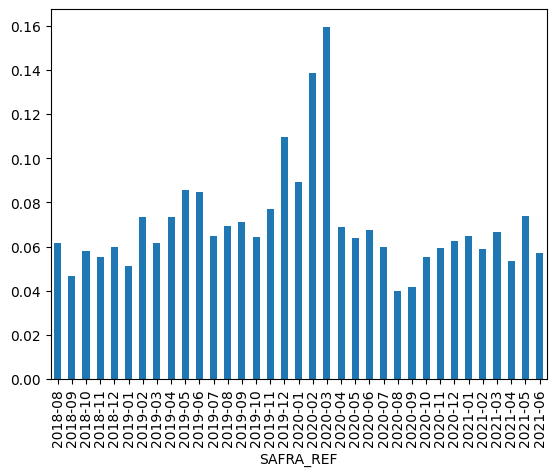

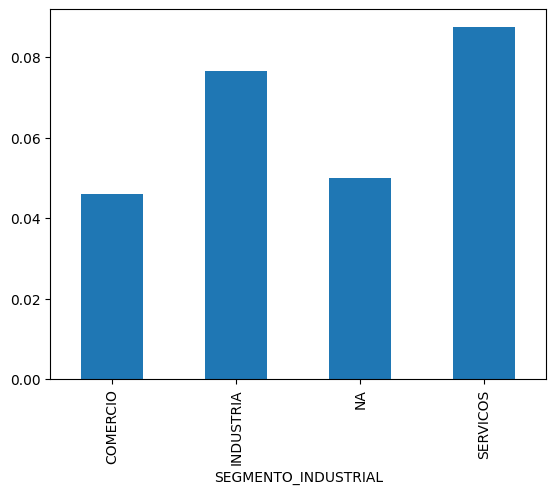

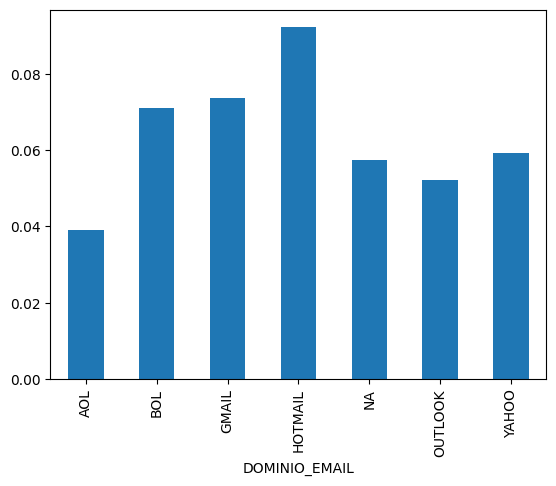

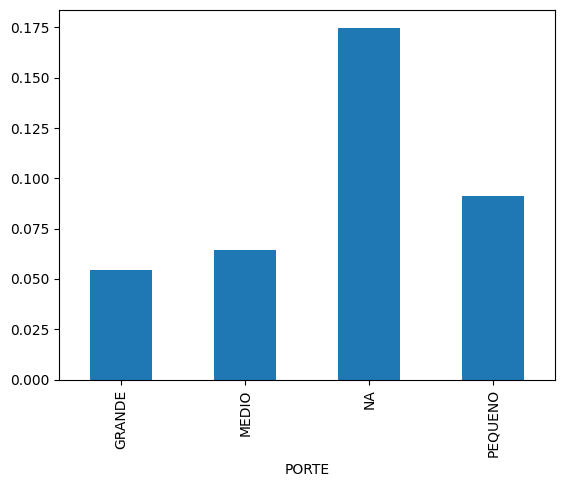

In [13]:
for col in useful_tex:
  if df_completo[col].nunique()<50:
    df_completo.groupby(col,dropna=False)['FLAG_MAU'].mean().sort_index().plot.bar()
    plt.show()

<Axes: >

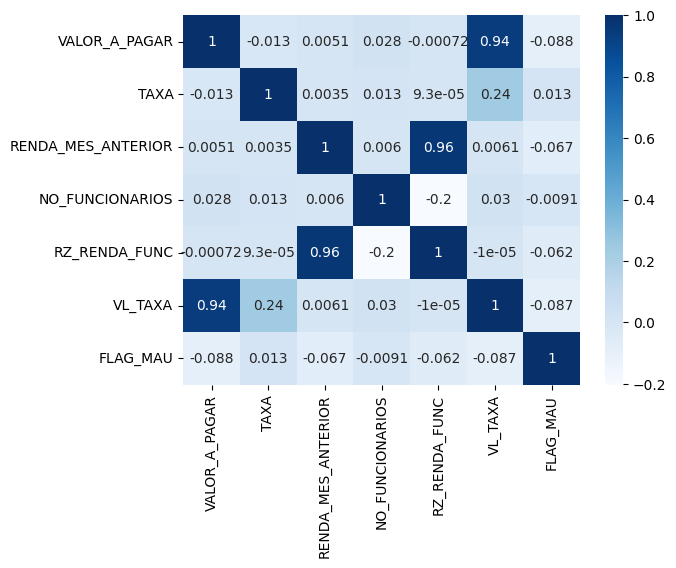

In [14]:
sns.heatmap(df_completo[useful_num + ['FLAG_MAU']].corr(),cmap='Blues',annot=True)

In [17]:
target='FLAG_MAU'
for col in useful_num:
    print(col+':','KS = ' + str(ks_score(y_true=df_completo[target], y_pred=df_completo[col])))

VALOR_A_PAGAR: KS = 35.75
TAXA: KS = 3.56
RENDA_MES_ANTERIOR: KS = 13.819999999999999
NO_FUNCIONARIOS: KS = 4.590000000000001
RZ_RENDA_FUNC: KS = 13.65
VL_TAXA: KS = 34.37
